## Import Library

In [2]:
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [2]:
# !pip install transformers

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

import os
import glob
import shutil
import random
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
import albumentations as A
from albumentations.pytorch import ToTensorV2
from transformers import get_cosine_schedule_with_warmup
from transformers import SegformerForSemanticSegmentation

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.8 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [4]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:128"


## Class Dataset

In [5]:
class BreastCancerDataset(Dataset):
    def __init__(self, root='/kaggle/input/breast-ultrasound-images-dataset/Dataset_BUSI_with_GT', is_train=True, transform=None):
        self.categories = ["benign", "malignant", "normal"]
        self.transform = transform
        self.path = glob.glob("{}/*/*_mask.png".format(root))

        random.seed(159)
        random.shuffle(self.path)
        if is_train:
            self.path = self.path[:int(len(self.path) * 0.85)]
        else:
            self.path = self.path[int(len(self.path) * 0.85):]
    
    def __len__(self):
        return len(self.path)
    
    def __getitem__(self, index):
        image = cv2.imread(self.path[index].replace("_mask.png", ".png"))
        mask = cv2.imread(self.path[index], cv2.IMREAD_GRAYSCALE)

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask[mask == 255] = 1

        if self.transform:
            transformed = self.transform(image=image, mask=mask)
            image, mask = transformed["image"], transformed["mask"]

        return image.float(), mask.float()

In [6]:
size = 512
train_transform = A.Compose([
    A.Resize(size, size),
    # A.RandomRotate90(),
    # A.GaussianBlur(),
    A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
    # A.CoarseDropout(max_height=25, max_width=25, fill_value=255),
    # A.ElasticTransform(alpha=1.0),
    A.HorizontalFlip(),
    A.Perspective(scale=(0.05, 0.1)),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2()
])

test_transform = A.Compose([
    A.Resize(size, size),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0),
    ToTensorV2()
])

## UnNormalized

In [7]:
class UnNormalized(object):
    def __init__(self, mean = [0.485, 0.456, 0.406], std = [0.229, 0.224, 0.225]):
        self.mean = mean
        self.std = std
    
    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
        return tensor

unNorm = UnNormalized()

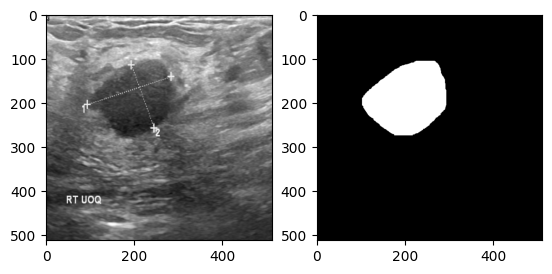

In [8]:
train_dataset = BreastCancerDataset(transform=train_transform)
test_dataset = BreastCancerDataset(is_train=False, transform=test_transform)
image, mask = train_dataset[random.randint(1, len(train_dataset))]
plt.subplot(1, 2, 1)
plt.imshow(unNorm(image).permute(1, 2, 0))
plt.subplot(1, 2, 2)
plt.imshow(mask, cmap='gray')
plt.show()

## AverageMeter

In [9]:
class AverageMeter(object):
    def __init__(self):
        self.reset()
    
    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0
    
    def update(self, val, n = 1):
        self.val += val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## Show Loss

In [10]:
def plot_segmentation_metrics(train_loss, val_loss, train_mean_iou=None, val_mean_iou=None, 
                              train_dice_score=None, val_dice_score=None):
    """
    Plot training and validation metrics (loss, mean IoU, Dice score) over epochs.

    Args:
    - train_loss (list): List of training loss values over epochs.
    - val_loss (list): List of validation loss values over epochs.
    - train_mean_iou (list, optional): List of training mean IoU values over epochs.
    - val_mean_iou (list, optional): List of validation mean IoU values over epochs.
    - train_dice_score (list, optional): List of training Dice score values over epochs.
    - val_dice_score (list, optional): List of validation Dice score values over epochs.
    """
    epochs = range(1, len(train_loss) + 1)
    
    plt.figure(figsize=(15, 10))
    
    # Plotting the Loss
    plt.subplot(2, 2, 1)
    plt.plot(epochs, train_loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'b', label='Val Loss')
    plt.title('Training and Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    # Plotting the Mean IoU (if available)
    if train_mean_iou and val_mean_iou:
        plt.subplot(2, 2, 2)
        plt.plot(epochs, train_mean_iou, 'r', label='Training Mean IoU')
        plt.plot(epochs, val_mean_iou, 'b', label='Val Mean IoU')
        plt.title('Training and Val Mean IoU')
        plt.xlabel('Epochs')
        plt.ylabel('Mean IoU')
        plt.legend()
    
    # Plotting the Dice Score (if available)
    if train_dice_score and val_dice_score:
        plt.subplot(2, 2, 3)
        plt.plot(epochs, train_dice_score, 'r', label='Training Dice Score')
        plt.plot(epochs, val_dice_score, 'b', label='Val Dice Score')
        plt.title('Training and Val Dice Score')
        plt.xlabel('Epochs')
        plt.ylabel('Dice Score')
        plt.legend()
    
    plt.tight_layout()
    plt.show()

## Calculate Intersection And Union

In [11]:
def intersectionAndUnionGPU(output, target, K, ignore_index=255):
    # 'K' classes, output and target sizes are N or N * L or N * H * W, each value in range 0 to K - 1.
    assert (output.dim() in [1, 2, 3])
    assert output.shape == target.shape
    output = output.view(-1)
    target = target.view(-1)
    output[target == ignore_index] = ignore_index
    intersection = output[output == target]
    area_intersection = torch.histc(intersection, bins=K, min=0, max=K-1)
    area_output = torch.histc(output, bins=K, min=0, max=K-1)
    area_target = torch.histc(target, bins=K, min=0, max=K-1)
    area_union = area_output + area_target - area_intersection
    return area_intersection, area_union, area_target

## Train

In [12]:
upsample = nn.Upsample(scale_factor=4, mode='bilinear')

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [15]:
def train(num_class, n_workers, batch_size, lr, epochs, checkpoint, saved_model):
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
    train_dataset = BreastCancerDataset(transform=train_transform)
    train_loader = DataLoader(
        dataset=train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=n_workers
    )
    
    test_dataset = BreastCancerDataset(is_train=False, transform=test_transform)
    test_loader = DataLoader(
        dataset=test_dataset,
        batch_size=batch_size,
        num_workers=n_workers
    )

    version = "nvidia/segformer-b3-finetuned-ade-512-512"
    model = SegformerForSemanticSegmentation.from_pretrained(version)
    
    in_channels = model.decode_head.classifier.in_channels
    model.decode_head.classifier = nn.Conv2d(in_channels, num_class, 1, 1)
    model.to(device)
    
    criterion = torch.nn.BCEWithLogitsLoss()
    optimizer = torch.optim.AdamW(params=model.parameters(), lr=lr, weight_decay=1e-4)
    
    num_batch = len(train_loader)
    
    scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer, total_iters=num_batch*epochs, power=0.9)

    
    if os.path.isdir(checkpoint):
        shutil.rmtree(checkpoint)
    os.makedirs(checkpoint)
    
    if not os.path.isdir(saved_model):
        os.makedirs(saved_model)
    
    writer = SummaryWriter(checkpoint)
    
    train_loss = []
    test_loss = []
    intersection_meter = AverageMeter()
    union_meter = AverageMeter()
    train_loss_meter = AverageMeter()
    test_loss_meter = AverageMeter()
    
    no_improvement_counter = 0
    patience = 10
    best_mIoU = -1
    
    for epoch in range(epochs):
        model.train()
        train_loss_meter.reset()
        test_loss_meter.reset()
        intersection_meter.reset()
        union_meter.reset()
        
        progress_bar = tqdm(train_loader, colour='cyan')
        
        for i, (image, mask) in enumerate(progress_bar):
            image, mask = image.to(device), mask.to(device)
            
            output = model(image).logits
            output = upsample(output).squeeze()
            loss = criterion(output, mask)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            train_loss_meter.update(loss.item())
            progress_bar.set_description(f"Train | Epoch {epoch + 1}/{epochs} | Loss {train_loss_meter.avg:.4f} | lr {optimizer.param_groups[0]['lr']}")
            writer.add_scalar("Train/Loss AVG", train_loss_meter.avg, num_batch * epoch + i)
            writer.add_scalar("Train/Loss", loss.item(), num_batch * epoch + i)
            scheduler.step()
        
        model.eval()
        with torch.no_grad():
            progress_bar = tqdm(iterable=test_loader, colour='yellow')
            
            for image, mask in progress_bar:
                image, mask = image.to(device), mask.to(device)
                
                output = model(image).logits
                output = upsample(output).squeeze()
                loss = criterion(output, mask)
                
                test_loss_meter.update(loss.item())
                output[output>=0.5] = 1
                output[output<0.5] = 0
                output = output.long()
                mask = mask.long()
                
                intersection, union, target = intersectionAndUnionGPU(output, mask, 2)           
                intersection_meter.update(intersection)
                union_meter.update(union)
                
                iou = intersection / (union + 1e-10)
                mean_iou = np.mean(iou.cpu().numpy())
                dice = 2 * intersection / (intersection + union + 1e-10)

                dice_value = dice.mean().item()
                
                intersection_meter.update(intersection)
                union_meter.update(union)
                test_loss_meter.update(loss.item())
                
                progress_bar.set_description(f"Val | Loss {loss.item():.4f} | mIoU: {mean_iou:.4f} | dice: {dice_value:.4f}")
            
            
            iou_class = intersection_meter.sum / (union_meter.sum + 1e-10)
            dice_class = 2 * intersection_meter.sum / (intersection_meter.sum + union_meter.sum + 1e-10)
            
            mIoU = iou_class.mean().item()
            mDice = dice_class.mean().item()
            print(f"Val | Loss {test_loss_meter.avg:.4f} | mIoU: {mIoU:.4f} | dice: {mDice:.4f}")
            
            writer.add_scalar("Val/Loss", test_loss_meter.avg, epoch)
            writer.add_scalar("Val/mIoU", mIoU, epoch)
            writer.add_scalar("Val/dice", mDice, epoch)
            
            checkpoint = {
                "model_state_dict": model.state_dict(),
                "optimizer_state_dict": optimizer.state_dict(),
                "epoch": epoch + 1,
                "mIoU": mIoU
            }
            
            torch.save(checkpoint, os.path.join(saved_model, "last.pt"))
            
            if mIoU > best_mIoU:
                best_mIoU = mIoU
                torch.save(checkpoint, os.path.join(saved_model, "best.pt"))
                no_improvement_counter = 0
            else:
                no_improvement_counter += 1
              
            train_loss.append(train_loss_meter.avg)
            test_loss.append(test_loss_meter.avg)
            
            if no_improvement_counter > patience:
                print("Early stopping!")
                break
    
    plot_segmentation_metrics(train_loss, test_loss)


In [14]:
torch.cuda.empty_cache()

import gc
gc.collect()

5941

2


config.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/190M [00:00<?, ?B/s]

  0%|          | 0/83 [00:00<?, ?it/s]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Train | Epoch 1/40 | Loss 0.4025 | lr 9.777433810859497e-05: 100%|██████████| 83/83 [03:45<00:00,  2.67s/it]/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
Train | Epoch 1/40 | Loss 0.4025 | lr 9.777433810859497e-05: 100%|██████████| 83/83 [03:45<00:00,  2.72s/it]
Val | Loss 0.3162 | mIoU: 0.7190 | dice: 0.8287: 100%|██████████| 15/15 [00:05<00:00,  2.51it/s]


Val | Loss 0.2983 | mIoU: 0.6822 | dice: 0.7915


Train | Epoch 2/40 | Loss 0.1775 | lr 9.551578556928773e-05: 100%|██████████| 83/83 [03:43<00:00,  2.69s/it]
Val | Loss 0.2594 | mIoU: 0.7427 | dice: 0.8455: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


Val | Loss 0.2176 | mIoU: 0.7427 | dice: 0.8409


Train | Epoch 3/40 | Loss 0.1267 | lr 9.325128281042073e-05: 100%|██████████| 83/83 [03:44<00:00,  2.70s/it]
Val | Loss 0.2644 | mIoU: 0.7241 | dice: 0.8327: 100%|██████████| 15/15 [00:05<00:00,  2.67it/s]


Val | Loss 0.1950 | mIoU: 0.7622 | dice: 0.8558


Train | Epoch 4/40 | Loss 0.1046 | lr 9.098065270944674e-05: 100%|██████████| 83/83 [03:42<00:00,  2.68s/it]
Val | Loss 0.2782 | mIoU: 0.7382 | dice: 0.8431: 100%|██████████| 15/15 [00:05<00:00,  2.67it/s]


Val | Loss 0.1995 | mIoU: 0.7615 | dice: 0.8552


Train | Epoch 5/40 | Loss 0.0904 | lr 8.870370779694773e-05: 100%|██████████| 83/83 [03:43<00:00,  2.70s/it]
Val | Loss 0.3024 | mIoU: 0.7112 | dice: 0.8224: 100%|██████████| 15/15 [00:05<00:00,  2.68it/s]


Val | Loss 0.1915 | mIoU: 0.7520 | dice: 0.8477


Train | Epoch 6/40 | Loss 0.0789 | lr 8.642024933873571e-05: 100%|██████████| 83/83 [03:43<00:00,  2.70s/it]
Val | Loss 0.5658 | mIoU: 0.6284 | dice: 0.7616: 100%|██████████| 15/15 [00:05<00:00,  2.69it/s]


Val | Loss 0.2939 | mIoU: 0.7161 | dice: 0.8224


Train | Epoch 7/40 | Loss 0.0727 | lr 8.413006630706826e-05: 100%|██████████| 83/83 [03:43<00:00,  2.70s/it]
Val | Loss 0.2878 | mIoU: 0.6548 | dice: 0.7744: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


Val | Loss 0.1935 | mIoU: 0.6987 | dice: 0.8029


Train | Epoch 8/40 | Loss 0.0657 | lr 8.183293422380903e-05: 100%|██████████| 83/83 [03:43<00:00,  2.70s/it]
Val | Loss 0.2713 | mIoU: 0.7296 | dice: 0.8367: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


Val | Loss 0.1752 | mIoU: 0.7745 | dice: 0.8644


Train | Epoch 9/40 | Loss 0.0682 | lr 7.952861385508157e-05: 100%|██████████| 83/83 [03:43<00:00,  2.69s/it]
Val | Loss 0.3351 | mIoU: 0.6727 | dice: 0.7904: 100%|██████████| 15/15 [00:05<00:00,  2.67it/s]


Val | Loss 0.2048 | mIoU: 0.7282 | dice: 0.8280


Train | Epoch 10/40 | Loss 0.0603 | lr 7.721684973293121e-05: 100%|██████████| 83/83 [03:43<00:00,  2.69s/it]
Val | Loss 0.2518 | mIoU: 0.6851 | dice: 0.8003: 100%|██████████| 15/15 [00:05<00:00,  2.68it/s]


Val | Loss 0.1746 | mIoU: 0.7384 | dice: 0.8360


Train | Epoch 11/40 | Loss 0.0495 | lr 7.489736847452167e-05: 100%|██████████| 83/83 [03:43<00:00,  2.70s/it]
Val | Loss 0.2171 | mIoU: 0.7608 | dice: 0.8580: 100%|██████████| 15/15 [00:05<00:00,  2.68it/s]


Val | Loss 0.1662 | mIoU: 0.7450 | dice: 0.8412


Train | Epoch 12/40 | Loss 0.0477 | lr 7.256987686317441e-05: 100%|██████████| 83/83 [03:43<00:00,  2.69s/it]
Val | Loss 0.1974 | mIoU: 0.7755 | dice: 0.8684: 100%|██████████| 15/15 [00:05<00:00,  2.67it/s]


Val | Loss 0.1824 | mIoU: 0.7721 | dice: 0.8621


Train | Epoch 13/40 | Loss 0.0497 | lr 7.023405964776426e-05: 100%|██████████| 83/83 [03:43<00:00,  2.69s/it]
Val | Loss 0.2320 | mIoU: 0.7979 | dice: 0.8838: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


Val | Loss 0.1816 | mIoU: 0.7759 | dice: 0.8654


Train | Epoch 14/40 | Loss 0.0440 | lr 6.788957700713169e-05: 100%|██████████| 83/83 [03:43<00:00,  2.69s/it]
Val | Loss 0.2299 | mIoU: 0.7719 | dice: 0.8665: 100%|██████████| 15/15 [00:05<00:00,  2.67it/s]


Val | Loss 0.1754 | mIoU: 0.7785 | dice: 0.8672


Train | Epoch 15/40 | Loss 0.0470 | lr 6.553606161362236e-05: 100%|██████████| 83/83 [03:44<00:00,  2.70s/it]
Val | Loss 0.3396 | mIoU: 0.7455 | dice: 0.8471: 100%|██████████| 15/15 [00:05<00:00,  2.67it/s]


Val | Loss 0.1913 | mIoU: 0.7781 | dice: 0.8665


Train | Epoch 16/40 | Loss 0.0430 | lr 6.317311521373353e-05: 100%|██████████| 83/83 [03:42<00:00,  2.69s/it]
Val | Loss 0.3433 | mIoU: 0.6962 | dice: 0.8092: 100%|██████████| 15/15 [00:05<00:00,  2.65it/s]


Val | Loss 0.1928 | mIoU: 0.7579 | dice: 0.8512


Train | Epoch 17/40 | Loss 0.0404 | lr 6.0800304622935465e-05: 100%|██████████| 83/83 [03:43<00:00,  2.69s/it]
Val | Loss 0.3077 | mIoU: 0.6490 | dice: 0.7696: 100%|██████████| 15/15 [00:05<00:00,  2.67it/s]


Val | Loss 0.1734 | mIoU: 0.7599 | dice: 0.8526


Train | Epoch 18/40 | Loss 0.0453 | lr 5.8417157004334684e-05: 100%|██████████| 83/83 [03:43<00:00,  2.70s/it]
Val | Loss 0.3007 | mIoU: 0.6804 | dice: 0.7973: 100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


Val | Loss 0.1638 | mIoU: 0.7591 | dice: 0.8523


Train | Epoch 19/40 | Loss 0.0379 | lr 5.60231542645741e-05: 100%|██████████| 83/83 [03:43<00:00,  2.70s/it]  
Val | Loss 0.2826 | mIoU: 0.7520 | dice: 0.8517: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


Val | Loss 0.1863 | mIoU: 0.7666 | dice: 0.8580


Train | Epoch 20/40 | Loss 0.0360 | lr 5.36177263517725e-05: 100%|██████████| 83/83 [03:43<00:00,  2.69s/it]  
Val | Loss 0.4058 | mIoU: 0.5884 | dice: 0.7124: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


Val | Loss 0.2074 | mIoU: 0.7365 | dice: 0.8344


Train | Epoch 21/40 | Loss 0.0368 | lr 5.120024317438288e-05: 100%|██████████| 83/83 [03:43<00:00,  2.69s/it] 
Val | Loss 0.3310 | mIoU: 0.7602 | dice: 0.8580: 100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


Val | Loss 0.1823 | mIoU: 0.7820 | dice: 0.8696


Train | Epoch 22/40 | Loss 0.0351 | lr 4.8770004769167756e-05: 100%|██████████| 83/83 [03:43<00:00,  2.70s/it]
Val | Loss 0.3327 | mIoU: 0.7723 | dice: 0.8662: 100%|██████████| 15/15 [00:05<00:00,  2.67it/s]


Val | Loss 0.1895 | mIoU: 0.7833 | dice: 0.8703


Train | Epoch 23/40 | Loss 0.0323 | lr 4.632622921984297e-05: 100%|██████████| 83/83 [03:44<00:00,  2.70s/it] 
Val | Loss 0.3356 | mIoU: 0.7722 | dice: 0.8662: 100%|██████████| 15/15 [00:05<00:00,  2.67it/s]


Val | Loss 0.1900 | mIoU: 0.7834 | dice: 0.8705


Train | Epoch 24/40 | Loss 0.0313 | lr 4.3868037648085164e-05: 100%|██████████| 83/83 [03:43<00:00,  2.69s/it]
Val | Loss 0.3136 | mIoU: 0.7657 | dice: 0.8622: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


Val | Loss 0.1883 | mIoU: 0.7846 | dice: 0.8715


Train | Epoch 25/40 | Loss 0.0315 | lr 4.1394435338402544e-05: 100%|██████████| 83/83 [03:44<00:00,  2.70s/it]
Val | Loss 0.3555 | mIoU: 0.7309 | dice: 0.8370: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


Val | Loss 0.1911 | mIoU: 0.7812 | dice: 0.8688


Train | Epoch 26/40 | Loss 0.0284 | lr 3.8904287674121e-05: 100%|██████████| 83/83 [03:43<00:00,  2.69s/it]   
Val | Loss 0.4178 | mIoU: 0.7132 | dice: 0.8252: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


Val | Loss 0.1911 | mIoU: 0.7880 | dice: 0.8740


Train | Epoch 27/40 | Loss 0.0326 | lr 3.6396288981041796e-05: 100%|██████████| 83/83 [03:44<00:00,  2.70s/it]
Val | Loss 0.3639 | mIoU: 0.7034 | dice: 0.8156: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


Val | Loss 0.1849 | mIoU: 0.7769 | dice: 0.8655


Train | Epoch 28/40 | Loss 0.0279 | lr 3.386892147459549e-05: 100%|██████████| 83/83 [03:44<00:00,  2.70s/it] 
Val | Loss 0.5342 | mIoU: 0.6992 | dice: 0.8148: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


Val | Loss 0.2340 | mIoU: 0.7673 | dice: 0.8590


Train | Epoch 29/40 | Loss 0.0268 | lr 3.132040006715775e-05: 100%|██████████| 83/83 [03:43<00:00,  2.70s/it] 
Val | Loss 0.4331 | mIoU: 0.7424 | dice: 0.8461: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


Val | Loss 0.2015 | mIoU: 0.7837 | dice: 0.8708


Train | Epoch 30/40 | Loss 0.0272 | lr 2.874859641312371e-05: 100%|██████████| 83/83 [03:43<00:00,  2.70s/it] 
Val | Loss 0.3879 | mIoU: 0.7065 | dice: 0.8183: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


Val | Loss 0.2100 | mIoU: 0.7766 | dice: 0.8654


Train | Epoch 31/40 | Loss 0.0276 | lr 2.6150931477882188e-05: 100%|██████████| 83/83 [03:43<00:00,  2.70s/it]
Val | Loss 0.4372 | mIoU: 0.7179 | dice: 0.8278: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


Val | Loss 0.1976 | mIoU: 0.7825 | dice: 0.8699


Train | Epoch 32/40 | Loss 0.0255 | lr 2.352421854511899e-05: 100%|██████████| 83/83 [03:44<00:00,  2.70s/it] 
Val | Loss 0.4896 | mIoU: 0.6975 | dice: 0.8129: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


Val | Loss 0.2089 | mIoU: 0.7806 | dice: 0.8685


Train | Epoch 33/40 | Loss 0.0255 | lr 2.086442453419739e-05: 100%|██████████| 83/83 [03:44<00:00,  2.70s/it] 
Val | Loss 0.5010 | mIoU: 0.7118 | dice: 0.8244: 100%|██████████| 15/15 [00:05<00:00,  2.64it/s]


Val | Loss 0.2144 | mIoU: 0.7865 | dice: 0.8730


Train | Epoch 34/40 | Loss 0.0258 | lr 1.81662888664925e-05: 100%|██████████| 83/83 [03:44<00:00,  2.70s/it]  
Val | Loss 0.5509 | mIoU: 0.6941 | dice: 0.8113: 100%|██████████| 15/15 [00:05<00:00,  2.65it/s]


Val | Loss 0.2208 | mIoU: 0.7791 | dice: 0.8677


Train | Epoch 35/40 | Loss 0.0245 | lr 1.5422675546095343e-05: 100%|██████████| 83/83 [03:44<00:00,  2.70s/it]
Val | Loss 0.4925 | mIoU: 0.7307 | dice: 0.8375: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


Val | Loss 0.2205 | mIoU: 0.7854 | dice: 0.8720


Train | Epoch 36/40 | Loss 0.0238 | lr 1.262337648002879e-05: 100%|██████████| 83/83 [03:44<00:00,  2.70s/it] 
Val | Loss 0.4696 | mIoU: 0.7258 | dice: 0.8337: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


Val | Loss 0.2113 | mIoU: 0.7846 | dice: 0.8714


Train | Epoch 37/40 | Loss 0.0237 | lr 9.752629650069748e-06: 100%|██████████| 83/83 [03:43<00:00,  2.70s/it] 
Val | Loss 0.4848 | mIoU: 0.7265 | dice: 0.8345: 100%|██████████| 15/15 [00:05<00:00,  2.65it/s]


Val | Loss 0.2157 | mIoU: 0.7892 | dice: 0.8748


Train | Epoch 38/40 | Loss 0.0231 | lr 6.782980190140072e-06: 100%|██████████| 83/83 [03:44<00:00,  2.70s/it] 
Val | Loss 0.4813 | mIoU: 0.7263 | dice: 0.8343: 100%|██████████| 15/15 [00:05<00:00,  2.67it/s]


Val | Loss 0.2159 | mIoU: 0.7876 | dice: 0.8736


Train | Epoch 39/40 | Loss 0.0223 | lr 3.6544925605027653e-06: 100%|██████████| 83/83 [03:43<00:00,  2.69s/it]
Val | Loss 0.4921 | mIoU: 0.7276 | dice: 0.8353: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


Val | Loss 0.2209 | mIoU: 0.7876 | dice: 0.8736


Train | Epoch 40/40 | Loss 0.0236 | lr 6.776036312050421e-08: 100%|██████████| 83/83 [03:43<00:00,  2.69s/it] 
Val | Loss 0.5009 | mIoU: 0.7256 | dice: 0.8343: 100%|██████████| 15/15 [00:05<00:00,  2.66it/s]


Val | Loss 0.2216 | mIoU: 0.7889 | dice: 0.8746


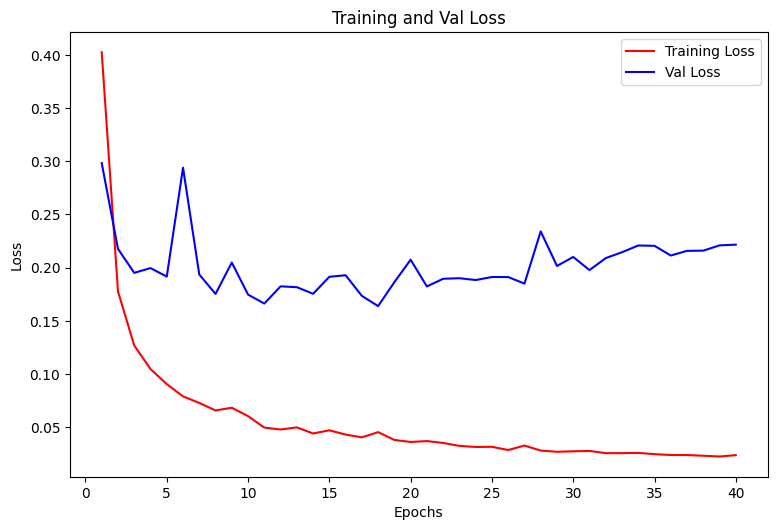

In [15]:
num_class = 1
n_workers = int(os.cpu_count() / 2)
print(n_workers)
batch_size = 8
lr = 1e-4
epochs = 40
checkpoint = "/kaggle/working/tensorboard"
saved_model = "/kaggle/working/saved_model"

train(num_class, n_workers, batch_size, lr, epochs, checkpoint, saved_model)

## Inference

In [16]:
def pred_show_image_grid(model_pth, device, test_dataset, num_classes, idx, num_imgs):
    # Load model checkpoint
    checkpoint = torch.load(model_pth)
    
    # Initialize and load model state
    model_name = "nvidia/segformer-b3-finetuned-ade-512-512"
    model = SegformerForSemanticSegmentation.from_pretrained(model_name)
    in_channels = model.decode_head.classifier.in_channels
    model.decode_head.classifier = nn.Conv2d(in_channels, num_class, 1, 1)
    model.to(device)
    
    model.load_state_dict(checkpoint['model_state_dict'])
    model.eval()
    # Load validation dataset
    
    images, orig_masks, pred_masks = [], [], []
    
    with torch.no_grad():
        for i in idx:
            ori_img, orig_mask = test_dataset[i]
            img = ori_img

            # Predict mask
            img = img.float().to(device).unsqueeze(0)
            # (B, 21, H, W) -> (B, 1, H, W) -> (B, H, W)
            pred_mask = upsample(model(img).logits).squeeze()
            pred_mask[pred_mask>=0.5] = 1
            pred_mask[pred_mask<0.5] = 0
            pred_mask = pred_mask.long().cpu().numpy()

            images.append(unNorm(ori_img).permute(1, 2, 0))
            orig_masks.append(orig_mask)
            pred_masks.append(pred_mask)

    
    # Combine images and masks for display
    images.extend(orig_masks)
    images.extend(pred_masks)
    
    # Plot images and masks
    fig = plt.figure(figsize=(20, 10))
    for i in range(1, 3*num_imgs + 1):
        fig.add_subplot(3, num_imgs, i)
        plt.imshow(images[i - 1])
    plt.show()



indexs = [87, 113, 24, 72, 110, 54, 88, 78]




/tmp/ipykernel_30/10437291.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(model_pth)


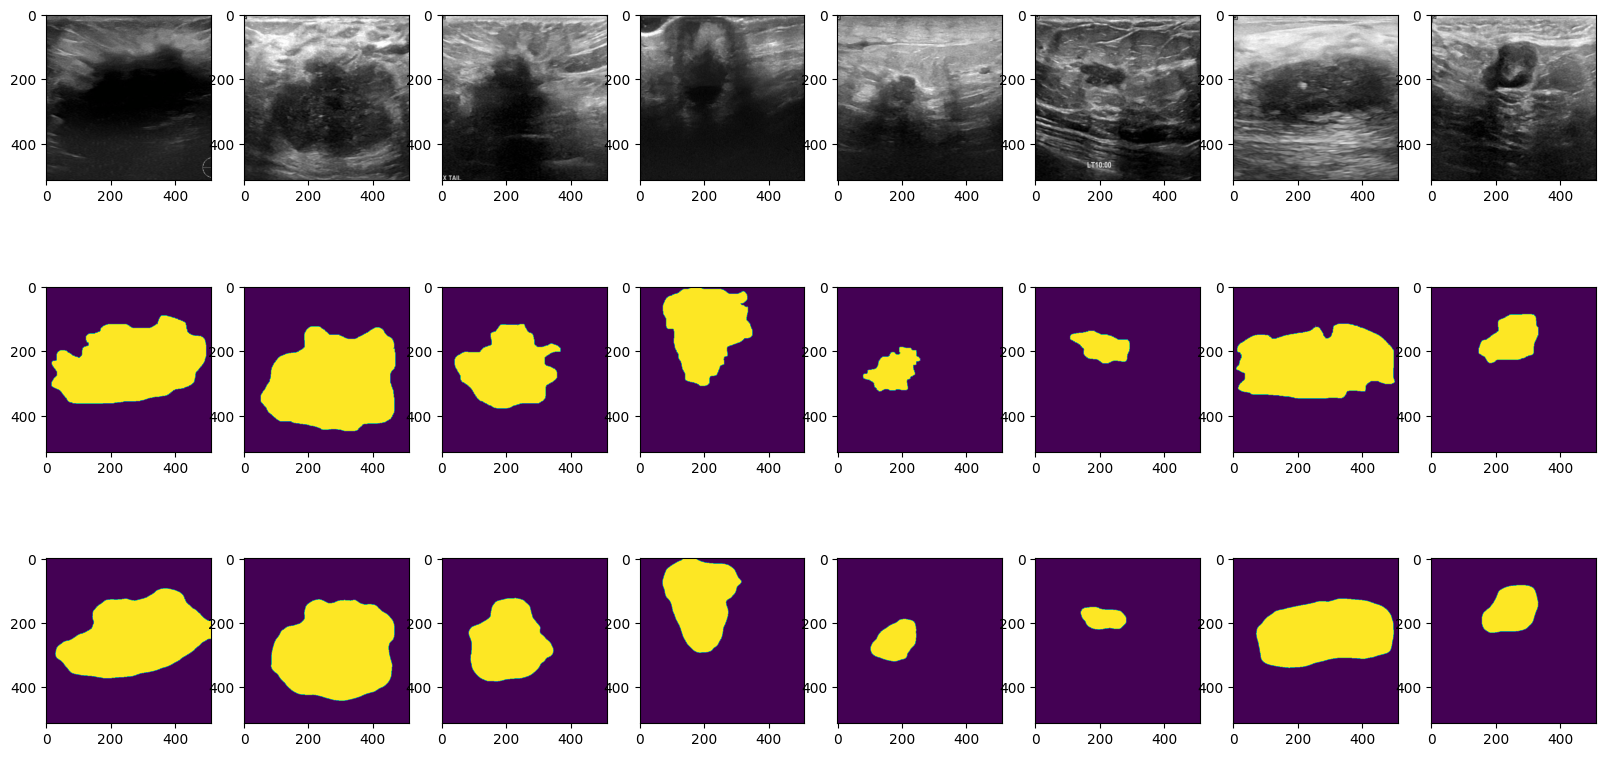

In [17]:
import random
#Note: You must train the model before using this param
model_pth = "/kaggle/working/saved_model/best.pt"
num_classes = 1
device = "cuda" if torch.cuda.is_available() else "cpu" 
print("\n")
indexs = random.sample(range(len(test_dataset)), 8)
print("indexs =", indexs)
print("\n")

#Show images
pred_show_image_grid(model_pth, device, test_dataset, num_classes, indexs, num_imgs= 8)